In [26]:
library(Seurat)
library(monocle)
library(tidyverse)
library(patchwork)

In [28]:
# read data
sce <- readRDS('outputs/microglia/micro_seu.rds')

In [31]:
sce <- subset(sce, sub_type == 'micro-2')

In [30]:
table(sce$sub_type)


micro-1 micro-2 
   8932    1354 

In [32]:
# sce@meta.data <- select(sce@meta.data, -contains("pANN"))
sce$nuclei_rename <- factor(sce$nuclei, levels = c("PVN", "DMH", "LAH", "VMH", "IN")
                                , labels = c("PVN", "DMH", "LHA", "VMH", "INF"))
sce$group <- sce$diabetes

# Prepare cds

In [33]:
sample_ann <-  sce@meta.data
gene_ann <- data.frame(
  gene_short_name = rownames(sce@assays$RNA) , 
  row.names =  rownames(sce@assays$RNA) 
)
head(gene_ann)

,gene_short_name
,<chr>
HSPD1,HSPD1
SUCLA2,SUCLA2
NKTR,NKTR
SLC22A15,SLC22A15
CCDC191,CCDC191
PTPRZ1,PTPRZ1


In [34]:
pd <- new("AnnotatedDataFrame",
          data=sample_ann)
fd <- new("AnnotatedDataFrame",
          data=gene_ann)
ct <- as.data.frame(sce@assays$RNA@counts)

In [35]:
sc_cds <- newCellDataSet(
  as.matrix(ct), 
  phenoData = pd,
  featureData =fd,
  expressionFamily = negbinomial.size(),
  lowerDetectionLimit=1)
sc_cds

CellDataSet (storageMode: environment)
assayData: 16283 features, 1354 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: CELL785_N1_1_1_1 CELL1155_N1_1_1_1 ... CELL2023_N1_31_1
    (1354 total)
  varLabels: orig.ident nCount_RNA ... Size_Factor (19 total)
  varMetadata: labelDescription
featureData
  featureNames: HSPD1 SUCLA2 ... TRAV27 (16283 total)
  fvarLabels: gene_short_name
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [36]:
sc_cds <- detectGenes(sc_cds, min_expr = 1) 
sc_cds <- sc_cds[fData(sc_cds)$num_cells_expressed > 20, ]
sc_cds

CellDataSet (storageMode: environment)
assayData: 9943 features, 1354 samples 
  element names: exprs 
protocolData: none
phenoData
  sampleNames: CELL785_N1_1_1_1 CELL1155_N1_1_1_1 ... CELL2023_N1_31_1
    (1354 total)
  varLabels: orig.ident nCount_RNA ... num_genes_expressed (20 total)
  varMetadata: labelDescription
featureData
  featureNames: HSPD1 SUCLA2 ... TLR5 (9943 total)
  fvarLabels: gene_short_name num_cells_expressed
  fvarMetadata: labelDescription
experimentData: use 'experimentData(object)'
Annotation:  

In [37]:
cds <- sc_cds
cds <- estimateSizeFactors(cds)
cds <- estimateDispersions(cds) 


Warning message in if (isSparseMatrix(counts)) {:
“the condition has length > 1 and only the first element will be used”
Warning message in if (isSparseMatrix(exprs(cds))) {:
“the condition has length > 1 and only the first element will be used”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message:
“step size truncated due to divergence”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message:
“step size truncated due to divergence”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message:
“step size truncated due to divergence”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message:
“step size truncated due to divergence”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message in log(ifelse(y == 0, 1, y/mu)):
“NaNs produced”
Warning message:
“step size truncated due to divergence”
Warning messag

Warning message:
“Transformation introduced infinite values in continuous y-axis”
Warning message:
“Transformation introduced infinite values in continuous y-axis”


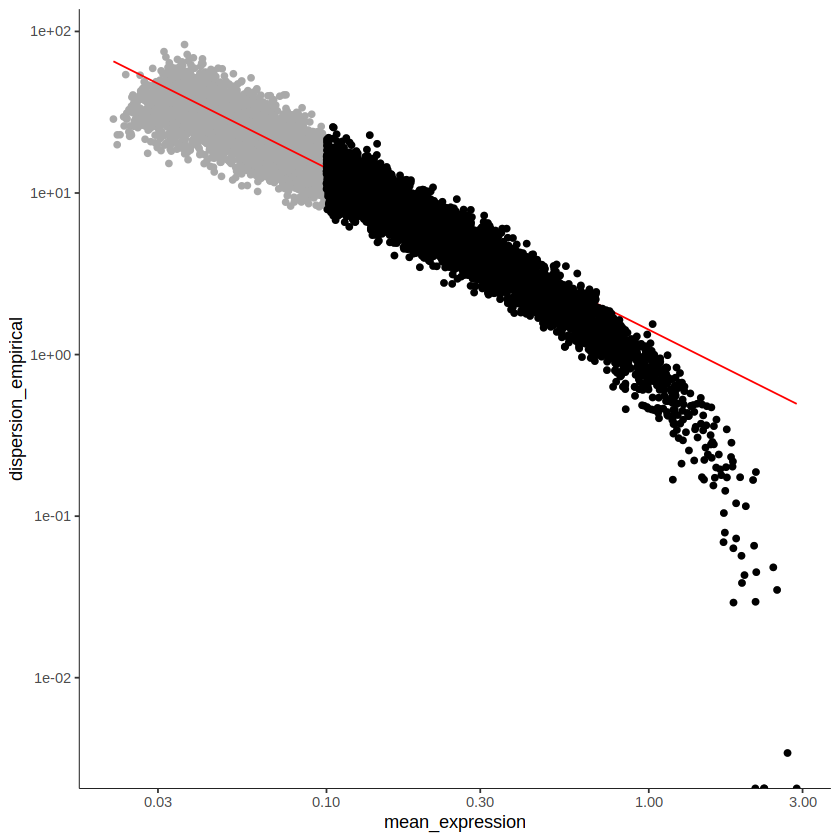

Remove noise by PCA ...

Reduce dimension by tSNE ...



Distance cutoff calculated to 2.760327 


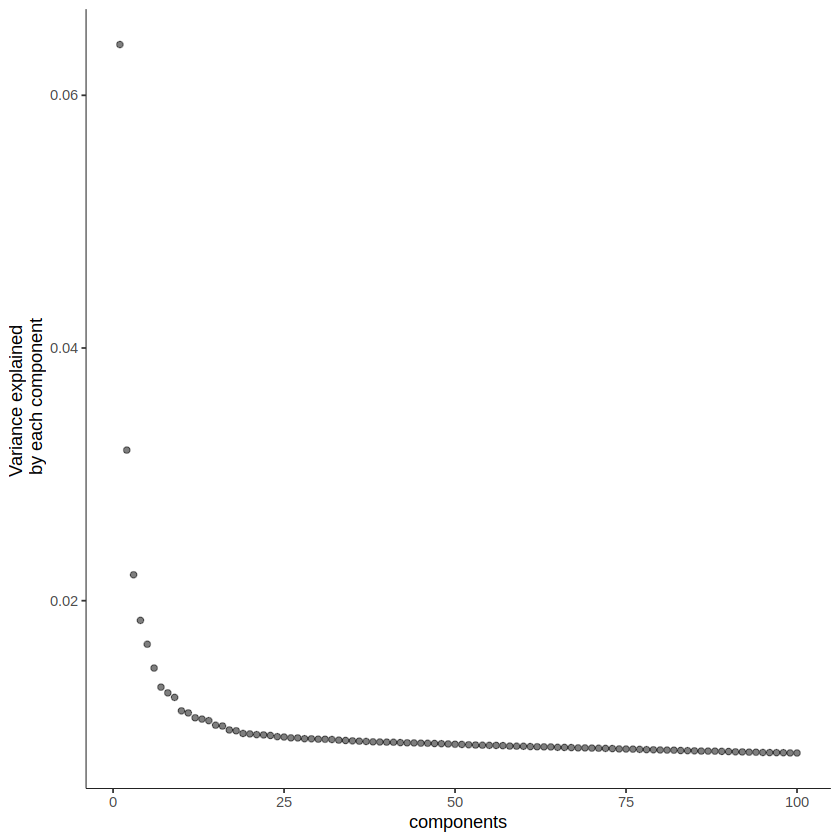


  1   2   3   4   5 
504 235 256 263  96 

[1] "orig.ident"                      "nCount_RNA"                     
 [3] "nFeature_RNA"                    "diabetes"                       
 [5] "doublet_info"                    "group"                          
 [7] "integrated_snn_res.0.5"          "monkey"                         
 [9] "nuclei"                          "percent.mt"                     
[11] "seurat_clusters"                 "split"                          
[13] "celltype"                        "subtype"                        
[15] "leiden"                          "cell_type"                      
[17] "sub_type"                        "nuclei_rename"                  
[19] "Size_Factor"                     "num_genes_expressed"            
[21] "Cluster"                         "peaks"                          
[23] "halo"                            "delta"                          
[25] "rho"                             "nearest_higher_density_neighbor"

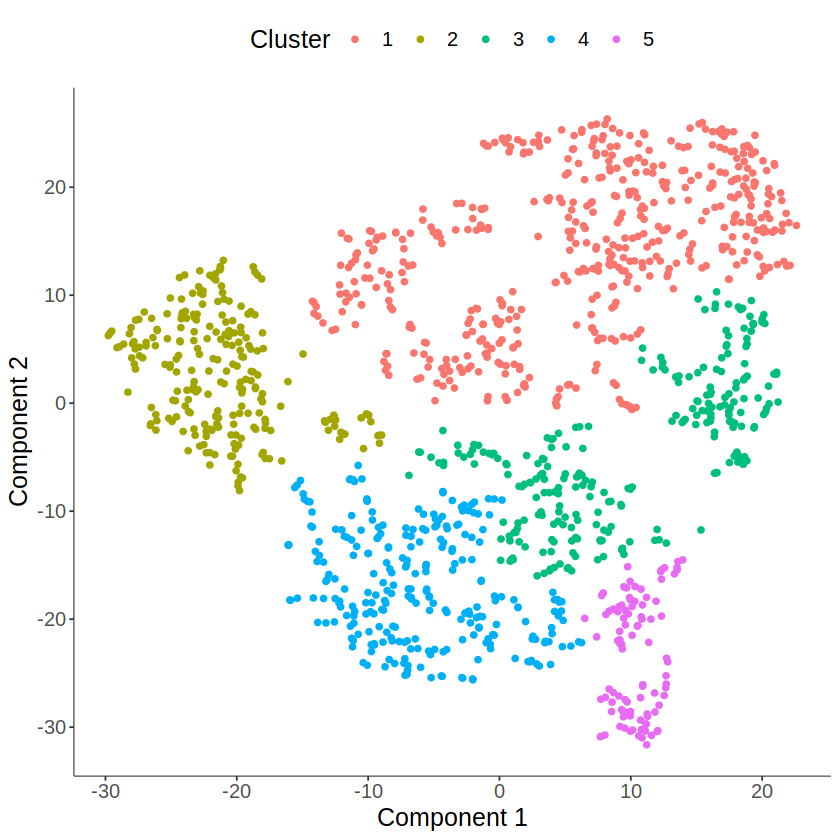

In [38]:
# 先进行挑选，合适的基因用来进行聚类。
disp_table <- dispersionTable(cds)
unsup_clustering_genes <- subset(disp_table, mean_expression >= 0.1)
cds <- setOrderingFilter(cds, unsup_clustering_genes$gene_id)
plot_ordering_genes(cds) 
plot_pc_variance_explained(cds, return_all = F) # norm_method='log'
# 其中 num_dim 参数选择基于上面的PCA图
cds <- reduceDimension(cds, max_components = 2, num_dim = 6,
                       reduction_method = 'tSNE', verbose = T, check_duplicates = FALSE)
cds <- clusterCells(cds, num_clusters = 6) 
plot_cell_clusters(cds, 1, 2 )
table(pData(cds)$Cluster)
colnames(pData(cds))

In [39]:
save(cds,file = 'outputs/micro_cds.Rdata')

# Perform monocle analysis

In [40]:
load(file = 'outputs/micro_processed_cds.Rdata')

In [51]:
db_con_deg <- read.csv('data/nn_DEG/micro-2_db_normal_all_genes.csv', row.names = 1)
ob_con_deg <- read.csv('data/nn_DEG/micro-2_ob_normal_all_genes.csv', row.names = 1)
micro_2.deg <- rbind(db_con_deg, ob_con_deg) %>% filter(abs(avg_log2FC) > log2(1.5) & p_val_adj < 0.05)

In [54]:
selected_genes <- rownames(micro_2.deg) %>% unique()

In [57]:
marker_genes <- row.names(subset(fData(cds),
                   gene_short_name %in% selected_genes))

In [58]:
marker_genes

[1] "TRPM3"     "PCDH9"     "SCAPER"    "NCAM1"     "MAP2"      "NRXN1"    
  [7] "RASAL2"    "ATP1A4"    "ITFG2"     "NTRK2"     "APC"       "MARCH1"   
 [13] "LRBA"      "NR3C2"     "FNDC3A"    "ATRX"      "PPM1L"     "KDELR3"   
 [19] "DPP10"     "POMC"      "WFS1"      "GPHN"      "PEG3"      "MX1"      
 [25] "CST3"      "CGA"       "LRRFIP2"   "MAP1B"     "NUCKS1"    "IFI27"    
 [31] "GNAS"      "CLU"       "SEC24C"    "SESN3"     "CDK14"     "LPP"      
 [37] "DKK3"      "SGK1"      "CERS6"     "CCSER1"    "CDKAL1"    "SRSF5"    
 [43] "MTIF2"     "LIMK2"     "AIG1"      "TNK2"      "TXNIP"     "ARHGAP15" 
 [49] "RNH1"      "PBX1"      "NRG3"      "GBP1"      "RFWD2"     "GRID2"    
 [55] "KCNIP4"    "SPARCL1"   "MAGI2"     "NUDT16L1"  "SNRNP70"   "UBB"      
 [61] "EVI5"      "PARD3"     "DST"       "ZBTB16"    "ATF7IP2"   "COMMD10"  
 [67] "DENND1B"   "ERBB4"     "CNTNAP2"   "PDE4D"     "SSBP2"     "SPATS2L"  
 [73] "PSME2"     "RASA1"     "PPP3CA"    "SLC1A3"    "WDR70"     "FGFR1"    
 [79] "BABAM1"    "RTN1"      "APP"       "RABGAP1L"  "NCKAP5"    "DMXL1"    
 [85] "RSF1"      "LRP11"     "VTI1A"     "ZSWIM6"    "HS2ST1"    "NRG1"     
 [91] "PRKACB"    "IFI44"     "DPY19L1"   "C12orf57"  "ANKS1B"    "LRP1B"    
 [97] "PLXDC2"    "RPS3A"     "DPP7"      "DUSP1"     "BMP2K"     "AMT"      
[103] "LTBR"      "ZSWIM8"    "SLC9A9"    "ANAPC5"    "UPF1"      "ADAM28"   
[109] "WIF1"      "ZEB2"      "GGT7"      "DNM3"      "PADI2"     "BTN3A1"   
[115] "CMTR1"     "HPS3"      "PTBP2"     "TRPS1"     "STK3"      "CPSF1"    
[121] "PALD1"     "HIBCH"     "FBXL17"    "ILF3"      "SAFB2"     "FYB1"     
[127] "CD163"     "COG4"      "VIM"       "DHX58"     "ALCAM"     "CYHR1"    
[133] "ARHGEF10L" "ARHGAP4"   "AKT3"      "NCOA2"     "EWSR1"     "CYFIP1"   
[139] "ACLY"      "KANK2"     "TFE3"      "SF1"       "KDM7A"     "GPC5"     
[145] "CTSC"      "TBC1D4"    "CPVL"      "PITPNA"    "UBE2E2"    "LMBRD1"   
[151] "TBC1D2B"   "CEP85L"    "ZFP36"     "SPARC"     "NF1"       "SST"      
[157] "LUC7L"     "MBNL1"     "ADAMTS10"  "STX3"      "WASF2"     "TEP1"     
[163] "ZNF200"    "CAMTA2"    "TLE3"      "PKN1"      "KANSL1L"   "GLUL"     
[169] "EVL"       "MXD4"      "TBC1D9"    "RAB2A"     "CPE"       "CD2AP"    
[175] "ATP9B"     "CRYM"      "MYOM1"     "FNBP1L"    "LAMB2"     "ADAM19"   
[181] "CNDP2"     "RGS2"      "PFKFB3"    "FER"       "PHF2"      "PARP9"    
[187] "FNIP1"     "UBE2W"     "SLC8A1"    "PJA2"      "MITF"      "RHBDF2"   
[193] "PSMC5"     "GGA3"      "RBCK1"     "N4BP2L2"   "LRP1"      "ROGDI"    
[199] "AP3B1"     "SRBD1"     "SLC2A5"    "SCAMP2"    "TMEM104"   "HERC3"    
[205] "MYO7A"     "LRCH1"     "PRIMPOL"   "LMBR1L"    "AP1S2"     "IRF9"     
[211] "IK"        "CLK1"      "BST2"      "TPM2"      "DNM2"      "FUK"      
[217] "CHD3"      "MAN1A2"    "PRIM2"     "STAT2"     "STX7"      "BTG2"     
[223] "PDE3B"     "ADAR"      "CREB1"     "ARPC1B"    "IMMP2L"    "CARMIL1"  
[229] "ALMS1"     "SASH3"     "ABCA3"     "TELO2"     "CORO1A"    "MAPKAPK3" 
[235] "KHNYN"     "SNX13"     "GNG2"      "PDK4"      "PLCB2"     "EYS"      
[241] "RGL2"      "NCKAP5L"   "TRIM25"    "FAM172A"   "RPS19BP1"  "ARHGAP45" 
[247] "MLLT6"     "NUMA1"     "DDX39B"    "SGPP1"     "ACSL1"     "DSTN"     
[253] "TREML1"    "ZBTB40"    "SLC43A2"   "BIN2"      "ARMC12"    "SSH1"     
[259] "RPP14"     "TYK2"      "CSNK1G2"   "CD1D"      "USP36"     "RGS14"    
[265] "MIS18BP1"  "KCNAB2"    "PIK3CD"    "STAT5B"    "CLASRP"    "AP5Z1"    
[271] "PML"       "OGFRL1"    "OTUD5"     "MAN2C1"    "CNPPD1"    "CHFR"     
[277] "PAN2"      "RAF1"      "FHOD1"     "MX2"       "IRF7"      "RNF114"   
[283] "FGD2"      "TOP1MT"    "WDR81"     "FN1"       "HUNK"      "DDIT4"    
[289] "STXBP2"    "IFI35"     "CDC37"     "ZNF7"      "VPS28"     "TRIP10"   
[295] "CLN3"      "GRK2"      "ATXN7L3"   "GRIPAP1"   "STAB1"     "ADPGK"    
[301] "EHMT1"     "PLA2G15"   "WDR1"      "PDE4A"     "DYNLT1"    "QSOX1"    
[307] "TNFSF12"   "NCF1"

In [59]:
diff_test_res <- differentialGeneTest(cds[marker_genes, ],
                                      fullModelFormulaStr = "~sm.ns(Pseudotime)")
sig_gene_names <- row.names(subset(diff_test_res, qval < 0.05))

Warning message in if (isSparseMatrix(exprs(X))) {:
“the condition has length > 1 and only the first element will be used”


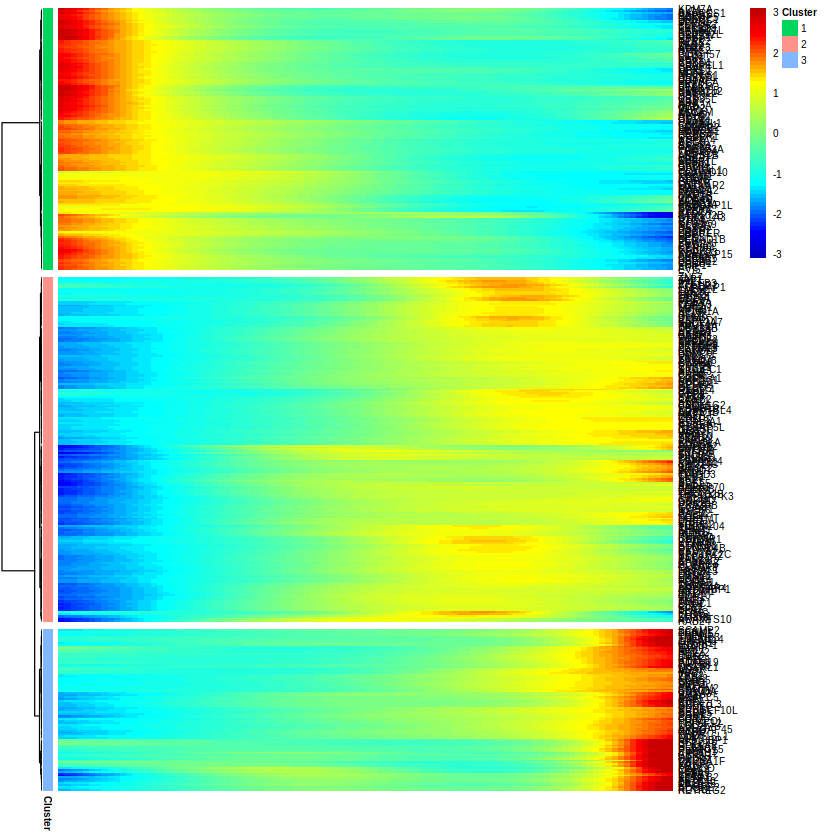

In [69]:
micro_heatmap <- plot_pseudotime_heatmap(cds[sig_gene_names,],
                    num_clusters = 3,
                    cores = 3,
                    show_rownames = T, return_heatmap = T)

In [73]:
pdf('outputs/micro_heatmap.pdf', height = 24, width = 4)
micro_heatmap
dev.off()

png 
  2